<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 *Logistic Regression*

# Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#  Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = 'titanic_train.csv'
titanic = pd.read_csv(titanic_csv)

In [3]:
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
## Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

# EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [4]:
titanic.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# ANSWER
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [76]:
def facetgridplot(train,var):
    facet = sns.FacetGrid(train, hue='Survived',aspect = 4)
    facet.map(sns.kdeplot,var,shade = True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

In [79]:
def bar_chart(train, feature):
    survived = train[train['Survived']==1][feature].value_counts(normalize=True)*100
    dead = train[train['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar', stacked=True, figsize=(10,5))

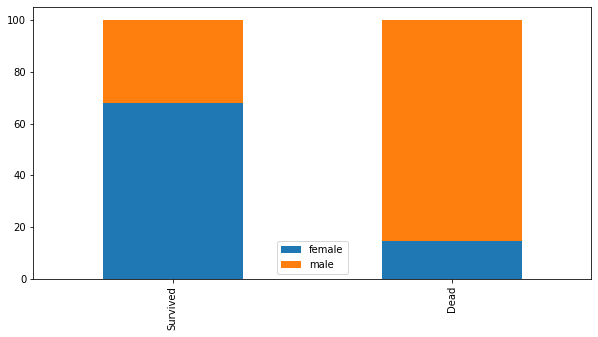

In [80]:
bar_chart(titanic, 'Sex')

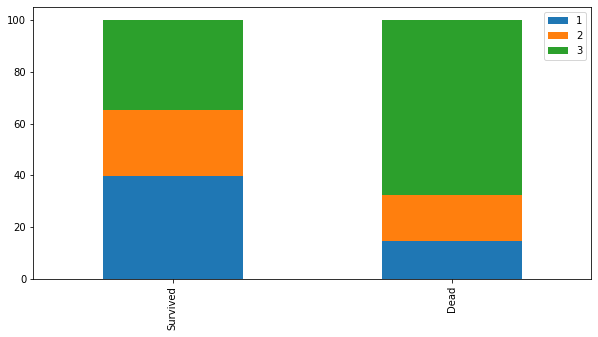

In [81]:
bar_chart(titanic, 'Pclass')

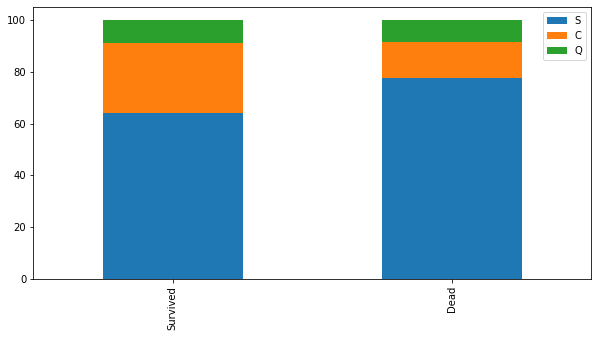

In [82]:
bar_chart(titanic, 'Embarked')

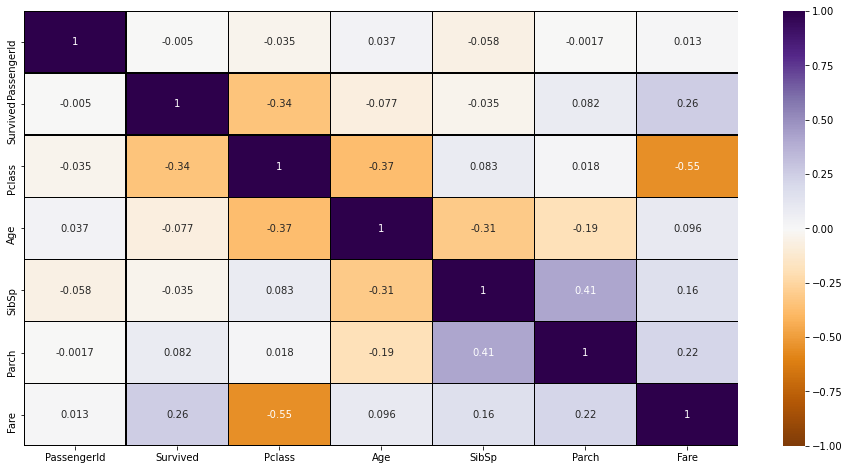

In [6]:
plt.figure(figsize=(16, 8))
corr = titanic.corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'PuOr', linewidths=0.5, linecolor='black')

### Age

In [7]:
titanic[titanic['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [8]:
# Check Age
# Check Median Age of Male, Female
titanic['Age'].fillna(titanic.groupby(by=['Sex'])['Age'].transform("median"), inplace=True) 

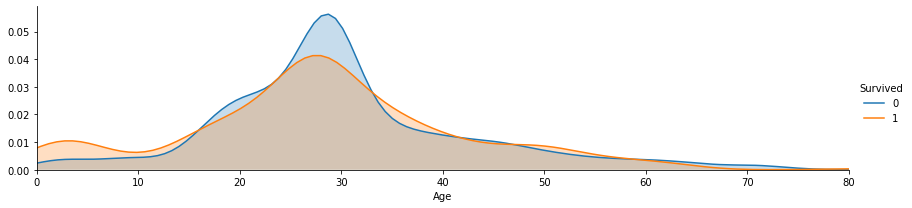

In [83]:
facetgridplot(titanic, 'Age')

### Fare

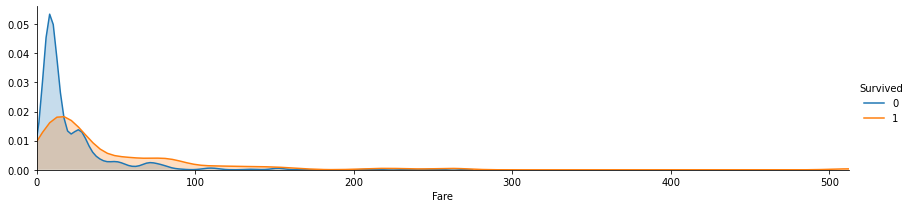

In [84]:
facetgridplot(titanic, 'Fare')

### Cabin

In [9]:
titanic[titanic['Cabin'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,27.0,1,2,W./C. 6607,23.4500,NaN,S


In [10]:
# Consider only the  first character as cabin number
titanic['Cabin'] = titanic['Cabin'].apply(lambda x: x[:1] if type(x) is str else x)

In [11]:
# Check Cabin
titanic['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [12]:
cabin_map = {
    'A': 1
    , 'B': 2
    , 'C': 3
    , 'D': 4
    , 'E': 5
    , 'F': 6
    , 'G': 7
    , 'T': 8
}
titanic['Cabin'] = titanic['Cabin'].map(cabin_map)

# Fill Cabin with Mean values
titanic['Cabin'].fillna(titanic.groupby(by=['Pclass'])['Cabin'].transform("mean"), inplace=True) 

# Remove Decimal Numbers
titanic['Cabin'] = np.round(titanic['Cabin'], decimals=0)

# Check Cabin
titanic['Cabin'].value_counts()

6.0    492
5.0    200
3.0     99
2.0     47
4.0     33
1.0     15
7.0      4
8.0      1
Name: Cabin, dtype: int64

### Embarked

In [13]:
titanic[titanic['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,2.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,2.0,NaN


In [14]:
titanic['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [15]:
#As 72% Passenger embarked from S. We can fill 2 rows of null values with S.
titanic['Embarked'] = titanic['Embarked'].apply(lambda x: x if type(x) is str else 'S')

# Numerical Predictors Only

## Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [16]:
X = titanic[['Parch','Pclass']]

In [17]:
Y = titanic['Survived']

## Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [18]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)


## Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [19]:
# ANSWER
# Create Model
logreg = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [20]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)


LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [21]:
# ANSWER
logreg.coef_

array([[ 0.337888  , -0.87239066]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [22]:
# ANSWER
logreg.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [23]:
# ANSWER
print(set(zip(['Parch','Pclass'],logreg.coef_[0])))

{('Parch', 0.33788800487797466), ('Pclass', -0.872390660601778)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [24]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Parch       +0.337888
Pclass      -0.872391


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [25]:
print ("So, Our accuracy Score is: {}".format(round(logreg.score(X_train, y_train),4)))

So, Our accuracy Score is: 0.6901


What is the  `accuracy_score` for the test data?

In [26]:
# ANSWER
print ("So, Our accuracy Score is: {}".format(round(logreg.score(X_test, y_test),4)))

So, Our accuracy Score is: 0.6682


What can we say aout this result?

ANSWER
- test set is predicted almost as well as training set
- overfitting seems unlikely

In [27]:
from sklearn import metrics

In [28]:
from sklearn.metrics import confusion_matrix
#Let's review the confusion Matrix to better understand the model
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred_class))

[[105  23]
 [ 51  44]]


In [29]:
print(np.asarray([['TN','FP'],['FN','TP']]))

#TP & FP -> Prediction
#TN & FN -> Actual
#TN 105, we predicted 51 FN to not survive but they did

[['TN' 'FP']
 ['FN' 'TP']]


## Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [30]:
# ANSWER
X = titanic[['Parch','Pclass','Age']]

In [31]:
# Build Model

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Fit Model
logreg.fit(X_train, y_train)

# Score
print ("So, Our accuracy Score is: {}".format(round(logreg.score(X_test, y_test),4)))

So, Our accuracy Score is: 0.6682


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age is not related to titanic survival
- Age is not independent of other features already in the model
- Adding of missing values distorted the distribution

Let's see where the model is going wrong by showing the Confusion Matrix:

In [32]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test,y_pred_class))

[[106  22]
 [ 52  43]]


Nb. Here is how `confusion_matrix` arranges its output:

In [33]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent? FP(Type 1 Error) or FN (type 2 error)

ANSWER: Type 2 (False Negative)

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

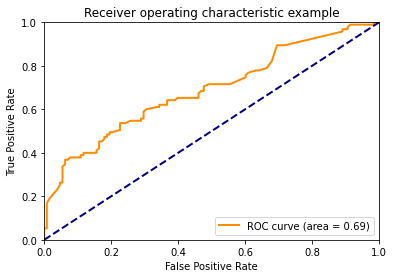

In [34]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

# Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [35]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,6.0,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3.0,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,6.0,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3.0,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,6.0,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [36]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [46]:
# Model ANSWER
# Set Feature Both Numerical, Categorical
def get_logreg_scores(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    #split
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1)

    #Build model
    logreg = LogisticRegression()

    #Fit
    logreg.fit(X_train, y_train)

    #score
    logreg_score = logreg.score (X_test, y_test)

    #Return accuracy rate
    return logreg_score


In [48]:
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1','Pclass_2','Pclass_3','Age','SibSp']
get_logreg_scores(titanic_with_dummies, feature_cols, target_col)


0.6547085201793722

Plot the ROC curve for the new model:

In [49]:
# ANSWER

def plot_roc_curve(X_test, y_test):
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = logreg.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

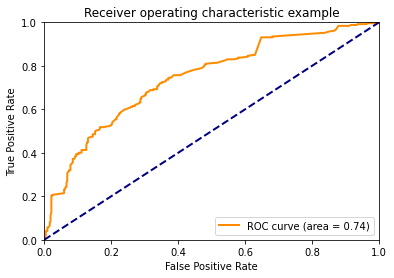

In [50]:
#train
plot_roc_curve(X_train, y_train)

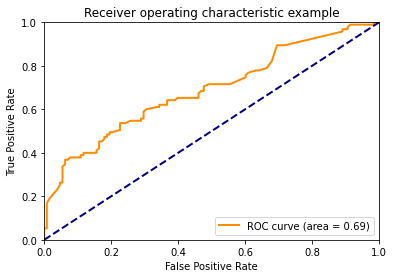

In [51]:
#test
plot_roc_curve(X_test, y_test)

#diff is about 0.5, hence no concern of overfitting

Can we improve the model by including the remaining features?

In [54]:
# ANSWER
target_col = 'Survived'
feature_cols = ['Age','SibSp','Parch','Fare',
                'Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S', 
                'Pclass_1','Pclass_2','Pclass_3']

get_logreg_scores(titanic_with_dummies, feature_cols, target_col)



/Users/wongkarmun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8026905829596412

In [57]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
100*ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(),
100*ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
100*ttwd[ttwd.Age < 16].Survived.mean(),len(ttwd[ttwd.Age < 16])
))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 59.04% of 83


In [59]:
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies[target_col]

#split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1)

#Build model
logreg = LogisticRegression()

#Fit
logreg.fit(X_train, y_train)

#Make a dataframe of results, including actual and predicted response:
y_hat = logreg.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame ({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)
y_actualdf = pd.DataFrame({'y_actual': y_actuals})
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

/Users/wongkarmun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,y_hat,y_actual,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [61]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
100*ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(),
100*ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
100*ttall[ttall.Age < 16].y_hat.mean(),len(ttall[ttall.Age < 16])
))

Male survival:  5.55% of 577
Female survival: 86.31% of 314
Child survival: 49.40% of 83


# Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

### 1 - Remove random state

In [67]:
X = titanic[['Parch','Pclass','Age']]

In [68]:

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.2)

In [69]:
logisticreg = LogisticRegression()

#Fit
logisticreg.fit(X_train, Y_train)

print(set(zip(X,logisticreg.coef_[0])))

{('Age', -0.03617244488281656), ('Parch', 0.1147585776100576), ('Pclass', -1.0492727623861642)}


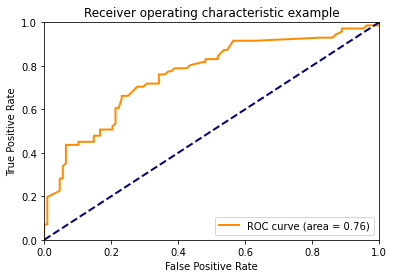

In [74]:
# ROC curve
preds = logisticreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(Y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Diff: 0.69 vs 0.76

### 2. Cross Validation

In [75]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'

feature_cols = ['Age','SibSp','Parch','Fare',
                'Sex_female','Sex_male','Embarked_C','Embarked_Q','Embarked_S', 
                'Pclass_1','Pclass_2','Pclass_3']

logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols],titanic_with_dummies[target_col],cv=5)
scores.mean()

#Metric returns accuracy score

/Users/wongkarmun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongkarmun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

0.795744146632352

© 2020 Institute of Data